# Designing Quantum Error-Correcting Codes

This notebook serves as the extraction of results from the implementation in the other python files in this project.

In [1]:
%matplotlib inline

/home/angelo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import numpy as np
import stim
import sinter
import model

import matplotlib.pyplot as plt

In [3]:
# Edit matplotlib parameters
plt.rcParams.update({
    'text.usetex': True,  # WARNING: make false if no TeX compiler installed
    'font.family': "Serif",
    'figure.dpi': 300
})

## Surface Code and Decoding Experimentation

We start with generating a surface code from our standalone implementation.

In [4]:
surface_code = model.StabilizerModel("surface_code:x_memory", scale=(3,3), rounds=2)

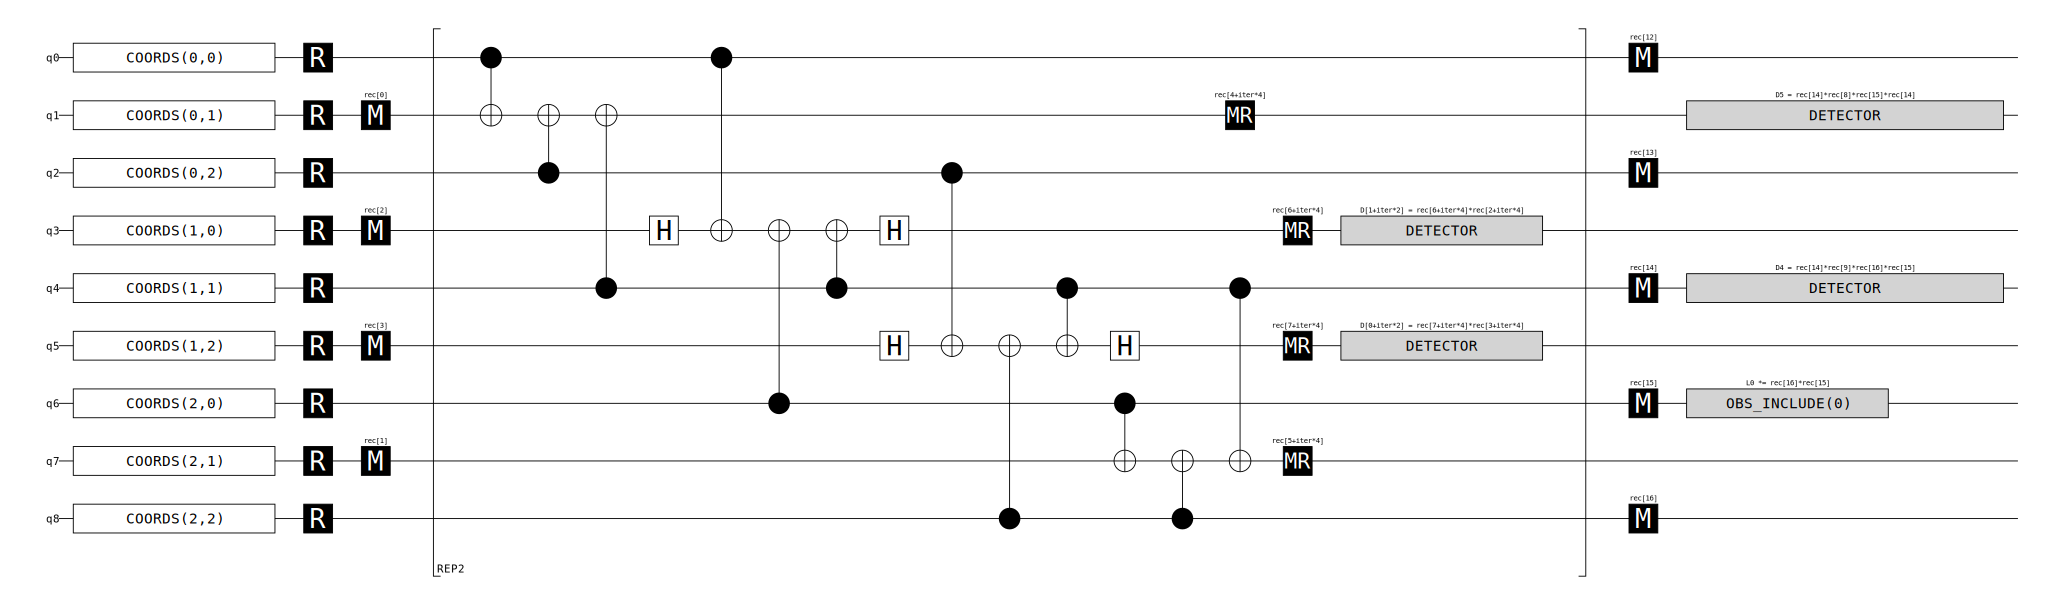

In [5]:
surface_code.circuit.without_noise().diagram("timeline")

In [6]:
surface_code_tasks = [
    sinter.Task(
        circuit=model.StabilizerModel(
            "surface_code:z_memory",
            scale=(distance, distance),
            rounds=distance * 3,
            noise_circuit=0.0,
            noise_data=noise,
            noise_x_check=noise,
            noise_z_check=noise,
        ).circuit,
        json_metadata={"distance": distance, "round": distance * 3, "noise": noise},
    )
    for distance in [5, 7, 9]
    for noise in np.linspace(0.001, 0.10, 40)
]

In [7]:
collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 4 workers...
120 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {distance=5,noise=0.001,round=15}
    pymatching processes=1  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {distance=5,noise=0.0035384615384615385,round=15}
    pymatching processes=1  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {distance=5,noise=0.006076923076923077,round=15}
    pymatching processes=1  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {distance=5,noise=0.008615384615384615,round=15}
100 cases left:
    pymatching processes=1  ~core_mins_left=1       shots_left=992195   errors_left=2042    {distance=5,noise=0.05176923076923077,round=15}
    pymatching processes=3  ~core_mins_left=1       shots_left=995700   errors_left=3335    {distance=5,noise=0.05430769230769231,round=15}
    pymatching processes=0  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {distance=5,noise=0.0568

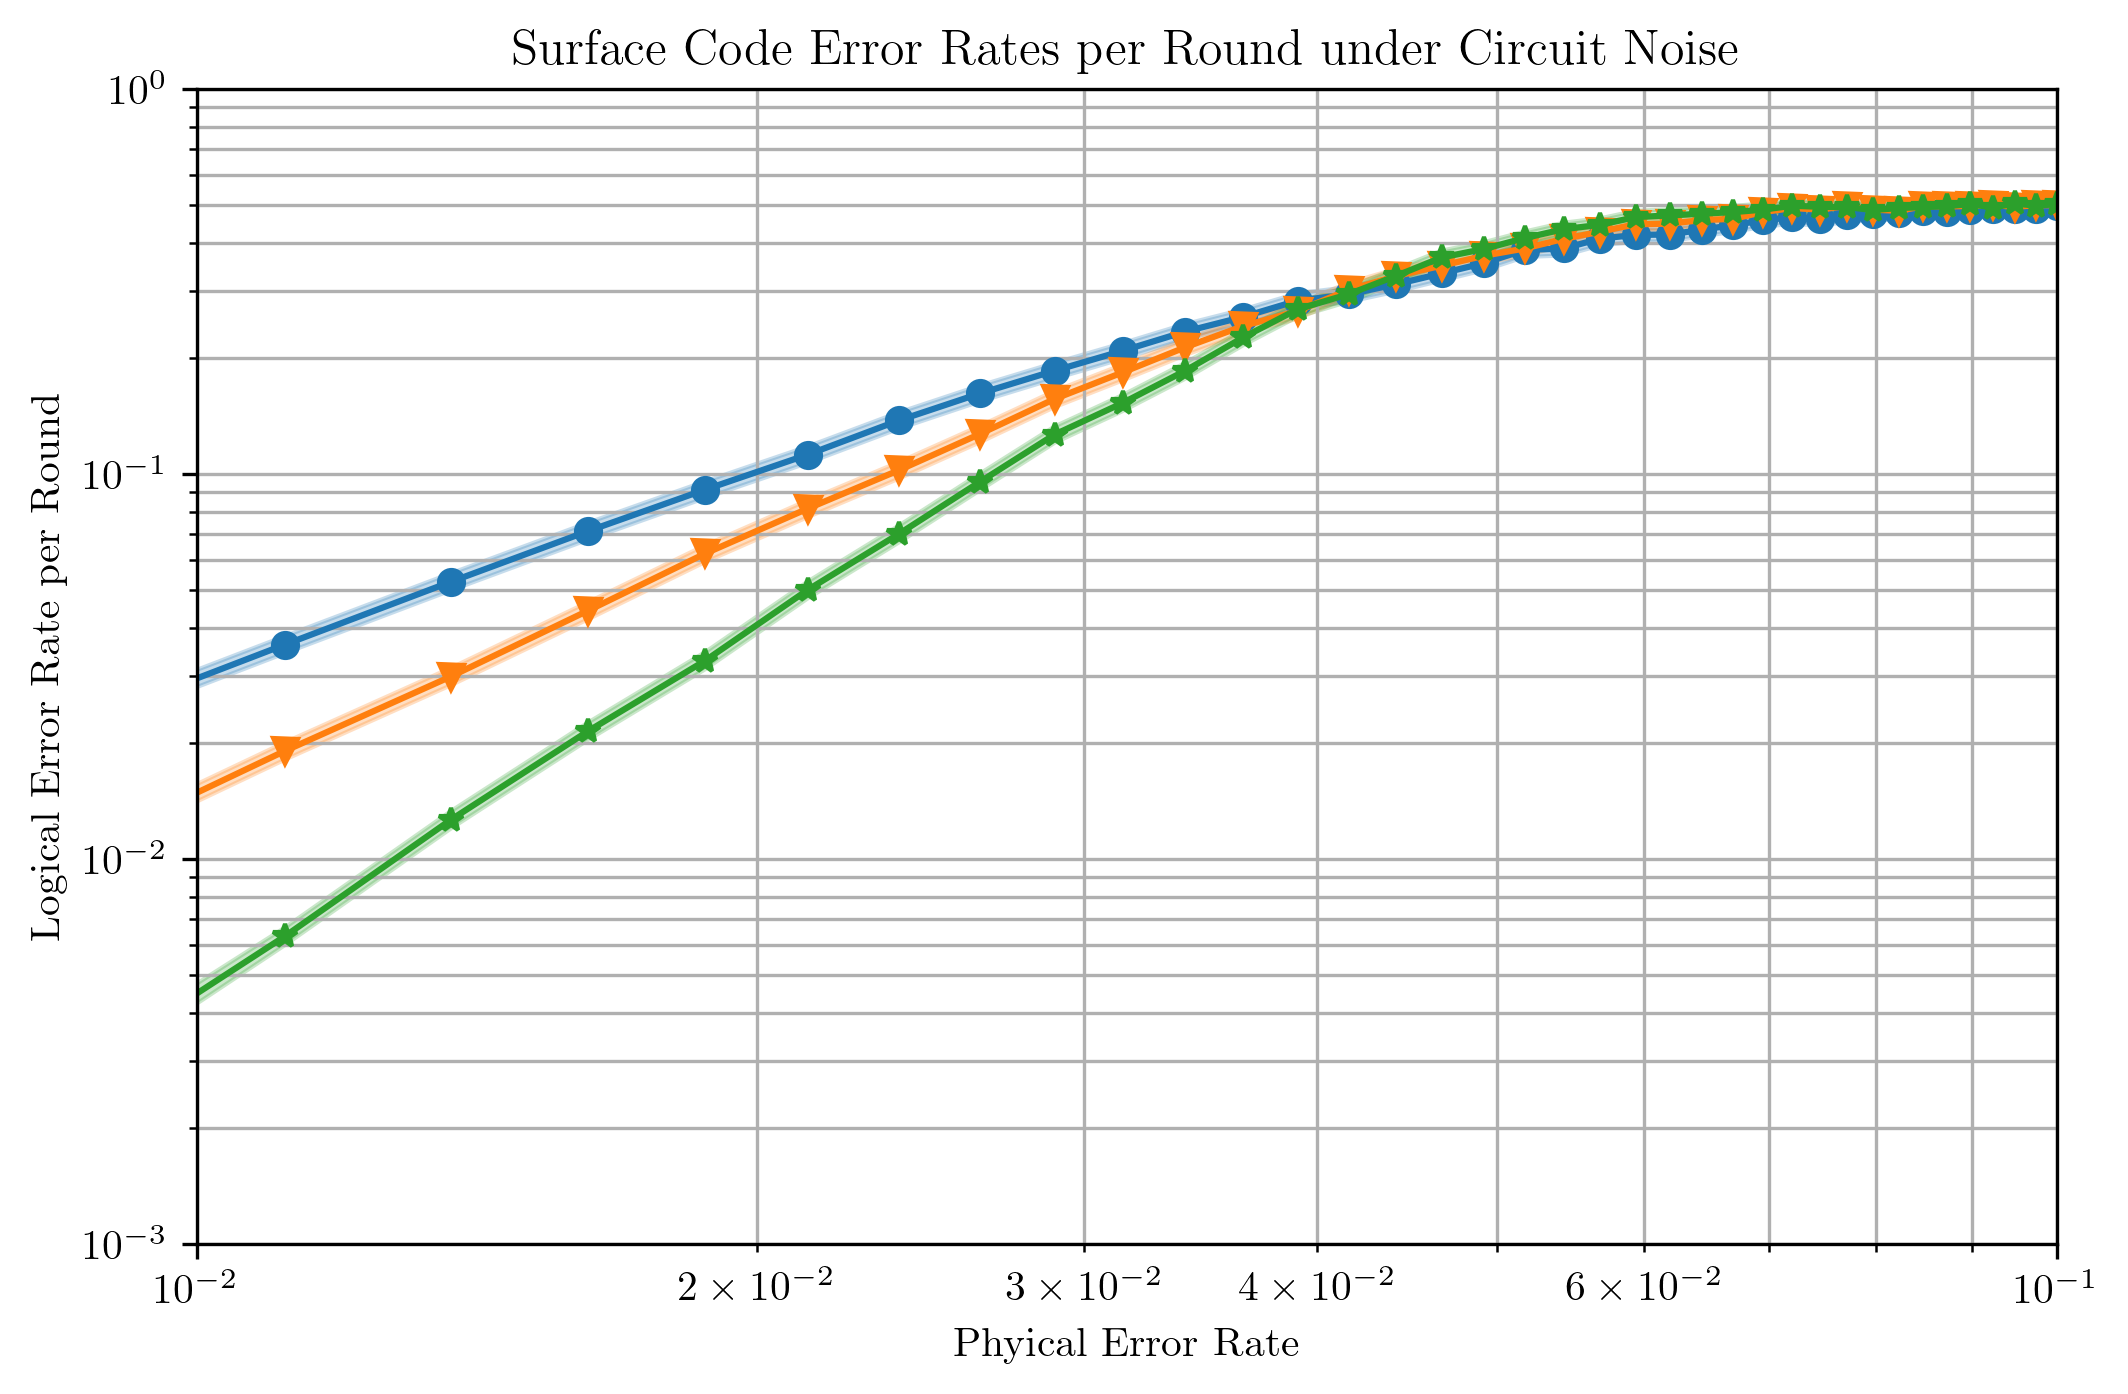

In [8]:
fig = plt.figure(figsize=(8, 5))
sinter.plot_error_rate(
    ax=fig.gca(),
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['noise'],
    group_func=lambda stat: stat.json_metadata['distance'],
)
plt.ylim(1e-3, 1)
plt.xlim(1e-2, 0.1)
plt.loglog()
plt.title("Surface Code Error Rates per Round under Circuit Noise")
plt.xlabel("Phyical Error Rate")
plt.ylabel("Logical Error Rate per Round")
plt.grid(which='major')
plt.grid(which='minor')

## Hypergraph Product Codes: Initial Experimentation

We start with the HP code between the 3-repetition and $\text{Hamming}[7,4]$ codes. A classical code is represented as a `clist`, comprised of the order of bits `"B"` and checks `"C"`. Following the latter is a sequence of integers indicating the bit indices in the code which are to be included in the parity check.

The position of the qubits is given via the `pos` argument, which is yet to be implemented.

In [9]:
clist_hamming = ["B", "C", 0, 1, 5, 6, "B", "B", "C", 1, 2, 4, 5, "B", "B", "B", "C", 3, 4, 5, 6, "B"]
clist_rep = ["B", "C", 0, 1, "B", "C", 1, 2, "B"]
hp_code = model.StabilizerModel("hypergraph_product_code:x_memory", clist1=clist_rep, clist2=clist_hamming, pos=1, rounds=2)